## Предобработка данных и применение Моделей ML: лог. регрессия, градиентный бустинг, дерево, k-NN. Сравнение с помощью метрик AUC ROC, точность, гибкость, accuracy_score, F-мера

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [29]:
df=pd.read_csv("german_data_01.csv")
df=df.iloc[:,1:]
df.head()

,age,gap_age,sex,job,type_job,housing,saving_accounts,checking_account,credit_amount,duration,gap_duration,purpose,risk,monthly_pay,credit_amount^2
0,67,50-75,male,2,skilled,own,NaN,little,1169,6,0-12,radio/TV,good,194.833333,1366561
1,22,0-25,female,2,skilled,own,little,moderate,5951,48,48-60,radio/TV,bad,123.979167,35414401
2,49,40-50,male,1,resident,own,little,NaN,2096,12,12-24,education,good,174.666667,4393216
3,45,40-50,male,2,skilled,free,little,little,7882,42,36-48,furniture/equipment,good,187.666667,62125924
4,53,50-75,male,2,skilled,free,little,little,4870,24,24-36,car,bad,202.916667,23716900


# Предобработка данных

In [30]:
df["age"],df["duration"],df["job"]=df["gap_age"],df["gap_duration"],df["type_job"]
df=df.drop(["gap_age","gap_duration","type_job"],axis=1)

In [31]:
liste_columns=list(df.columns)
liste_columns.remove("sex")
liste_columns.remove("risk")
liste_columns.remove("credit_amount")
liste_columns.remove("monthly_pay")
liste_columns.remove("credit_amount^2")
liste_columns

['age',
 'job',
 'housing',
 'saving_accounts',
 'checking_account',
 'duration',
 'purpose']

Это факторные переменные, мы потом их преобразуем в фиктивные

### one-hot кодировка

In [33]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df["sex"]=label.fit_transform(df["sex"])
df["risk"]=label.fit_transform(df["risk"])
df=pd.get_dummies(df,columns=liste_columns,prefix=liste_columns)

In [34]:
df

,sex,credit_amount,risk,monthly_pay,credit_amount^2,age_0-25,age_25-30,age_30-35,age_35-40,age_40-50,...,duration_48-60,duration_60-72,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,1,1169,1,194.833333,1366561,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,5951,0,123.979167,35414401,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,2096,1,174.666667,4393216,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,7882,1,187.666667,62125924,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,4870,0,202.916667,23716900,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1736,1,144.666667,3013696,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
996,1,3857,1,128.566667,14876449,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
997,1,804,1,67.000000,646416,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
998,1,1845,0,41.000000,3404025,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Нормализация и изменение распределения. Для больших значений переменных добьемся преобразованием между 0 и 1.

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df["credit_amount"]=scaler.fit_transform(df[["credit_amount"]])
df["monthly_pay"]=scaler.fit_transform(df[["monthly_pay"]])
df["credit_amount^2"]=scaler.fit_transform(df[["credit_amount^2"]])

In [44]:
df.head()

,sex,credit_amount,risk,monthly_pay,credit_amount^2,age_0-25,age_25-30,age_30-35,age_35-40,age_40-50,...,duration_48-60,duration_60-72,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,1,0.050567,1,0.069461,0.003842,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0.313690,0,0.040642,0.104166,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0.101574,1,0.061259,0.012761,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,0.419941,1,0.066546,0.182872,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,0.254209,0,0.072749,0.069699,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## ML

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,auc,classification_report, plot_roc_curve

In [152]:
X=df.drop(["risk"],axis=1) # удаляем целевую метку
Y=df["risk"] # целевая метка
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0) # тренировочные и тестовые периоды, выберем тестовый 0.3 доли

## Дерево решений, метрики accuracy_score, Precision, recall и F-мера

In [153]:
from sklearn.tree import DecisionTreeClassifier
cart_model=DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_leaf=5,min_samples_split=2).fit(X_train,Y_train)

In [154]:
print("Train Accuracy Score : ",accuracy_score(Y_train,cart_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,cart_model.predict(X_test)))

Train Accuracy Score :  0.8057142857142857
Test Accuracy Score :  0.6733333333333333


Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

F-мера достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

In [155]:
print(classification_report(Y_test,cart_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.41      0.31      0.36        86
           1       0.75      0.82      0.78       214

    accuracy                           0.67       300
   macro avg       0.58      0.57      0.57       300
weighted avg       0.65      0.67      0.66       300



дерево решений в данном случае плохо обнаруживает 0 класс, плохая точность 0 класса.

## Градиентный бустинг

In [156]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(learning_rate = 0.01,max_depth = 5,min_samples_split = 10,n_estimators = 100).fit(X_train, Y_train)

In [157]:
print("Train Accuracy Score : ",accuracy_score(Y_train,gbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,gbm_model.predict(X_test)))

Train Accuracy Score :  0.8385714285714285
Test Accuracy Score :  0.7433333333333333


In [158]:
print(classification_report(Y_test,gbm_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.20      0.31        86
           1       0.75      0.96      0.84       214

    accuracy                           0.74       300
   macro avg       0.71      0.58      0.57       300
weighted avg       0.73      0.74      0.69       300



Лучше точность по 0 классу, но recall меньше

## Логистическая регрессия

In [159]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train, Y_train)

print(classification_report(Y_test,logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.43      0.49        86
           1       0.79      0.87      0.83       214

    accuracy                           0.74       300
   macro avg       0.68      0.65      0.66       300
weighted avg       0.73      0.74      0.73       300



In [160]:
print("Train Accuracy Score : ",accuracy_score(Y_train,logreg.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,logreg.predict(X_test)))

Train Accuracy Score :  0.75
Test Accuracy Score :  0.7433333333333333


## Метод k ближайших соседей

In [161]:
from sklearn.neighbors import KNeighborsClassifier
KN = KNeighborsClassifier(n_neighbors=20).fit(X_train, Y_train)

In [162]:
print("Train Accuracy Score : ",accuracy_score(Y_train,KN.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,KN.predict(X_test)))

Train Accuracy Score :  0.7442857142857143
Test Accuracy Score :  0.73


In [163]:
print(classification_report(Y_test,KN.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.17      0.27        86
           1       0.74      0.95      0.83       214

    accuracy                           0.73       300
   macro avg       0.67      0.56      0.55       300
weighted avg       0.70      0.73      0.67       300



## ROC AUC

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: Futu

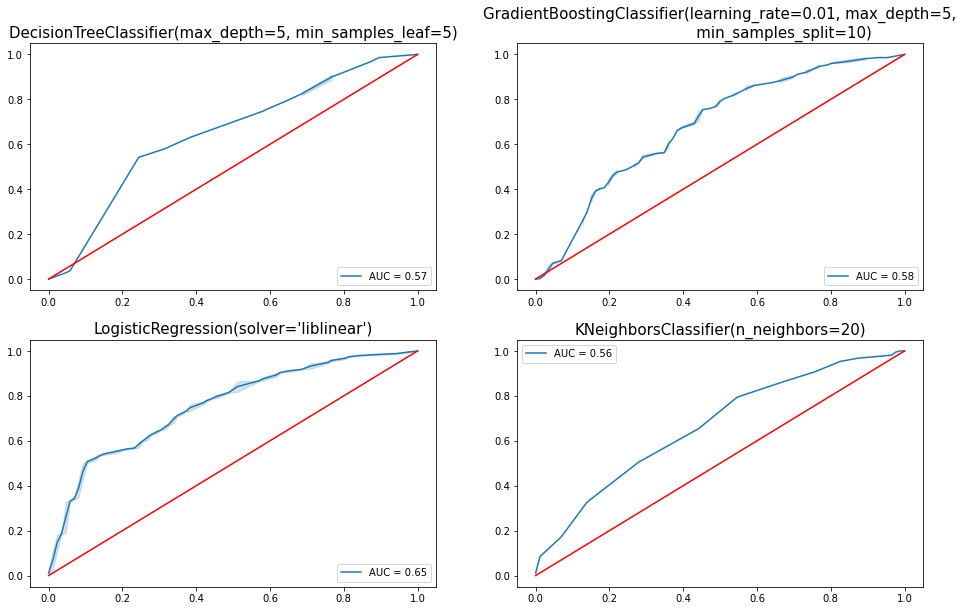

In [174]:
list_model=[cart_model, gbm_model,logreg, KN]
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(16,10))
count = 0
for i in range(2):
    for j in range(2):
        logit_roc_auc=roc_auc_score(Y_test,list_model[count].predict(X_test))
        fpr,tpr,thresholds = roc_curve(Y_test, list_model[count].predict_proba(X_test)[:,1])
        sns.lineplot(fpr,tpr,label="AUC = %0.2f"%logit_roc_auc,ax=ax[i][j])
        sns.lineplot([0,1],[0,1],color="red",ax=ax[i][j])
        ax[i][j].legend(loc="lower right")
        ax[i][j].set_title(list_model[count],fontsize=15)
        count += 1
plt.legend()
plt.show()

AUC ROC для логистической регрессии 0.65, это не очень результат, но в данном случае он самый высокий.

Вывод: лог регрессия себя показала лучше всего по AUC ROC(0.65), recall 0 класса тоже самый высокий, точность немного уступает k-NN и бустингу, хорошие показатели для 1 класса, однако этот класс является большинством. Лучшие показатели по f-мере. Поэтому суммируя все, лог. регрессия - лучший в данном случае алгоритм.